# Neural Network & Timeseries Forecasts

## Using the Tensorflow Saved TCN

#### Load the Architecture and Weights
Load the model like this:

```python
from tensorflow.keras.models import load_model

MODEL_PATH = "./models/tcn"
tcn=load_model(MODEL_PATH)
```

Model needs the following features:
- '**Max_Demand_GW**' - its autoregressive.
- '**Plant_Production_GWh**
- '**emissions_c02_GG**'
- '**tavg**', 
- '**GDP_bln**'
- '**date**' in `YYYY-DD-MM`, 

Predict label is nex horizon's: '**Max_Demand_GW**'

#### Prepare Data with Utility

The model is a simple one-step and needs a window of data (12 months), and will predict a horizon (next 1 month. or the 13th month).
You need to prepare the data like so:

```python
def prepare_data_and_windows(data_df, window=12, horizon=1):
    """
    Utility function to prepare the data. Assuming features are:
        - 'Plant_Production_GWh
        - 'emissions_c02_GG'
        - 'tavg',
        - 'GDP_bln'
        - 'date' in YYYY-DD-MM,
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    MONTH_SINE = "month_sin"
    MONTH_COS = "month_cos"
    TARGET = "Max_Demand_GW"
    FEATURES = [
        "Plant_Production_GWh",
        "emissions_c02_GG",
        "tavg",
        "GDP_bln",
    ]
    INDEX = "Date"

    def _encode_timewindows(data_df, features, target, window_size, horizon):
        """
        Create input and target windows suitable for TCN model.

        :param data: DataFrame with shape (n_samples, n_features)
        :param features: List of strings, names of the feature columns
        :param target: String, name of the target column
        :param window_size: int, length of the input sequence
        :param horizon: int, forecasting horizon
        :return: Array in the shape of (n_samples, n_steps, n_features)
        """
        X, y = [], []
        for i in tqdm(
            range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"
        ):
            input_window = data_df[features].iloc[i : i + window_size].values
            X.append(input_window)

            # Target window
            if horizon == 1:
                target_value = data_df[target].iloc[i + window_size]
            else:
                target_value = (
                    data_df[target].iloc[i + window_size : i + window_size + horizon].values
                )
            y.append(target_value)
        return np.array(X), np.array(y)


    def _encode_cyclics(data_df):
        """
        Encodes time cyclic features for a dataset with monthly sampling.
        Assuming we can capture the yearly periodicity by encoding the month as a wave.
        See: https://www.tensorflow.org/tutorials/structured_data/time_series#time
        :param data_df: The timeseries with a date in the format YYYY-DD-mm as index.
        :return: data_df with 2 new wave features.
        """
        months = data_df.index.month

        data_df[MONTH_SINE] = np.sin(2 * np.pi * months / 12)
        data_df[MONTH_COS] = np.cos(2 * np.pi * months / 12)

        return data_df
    WINDOW_SIZE_MONTHS = 12
    EXT_FEATURES = FEATURES + [MONTH_SINE, MONTH_COS]

    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
    normalizer.adapt(data_df[FEATURES])
    data_df_normalized = normalizer(data_df[FEATURES])
    data_df_normalized = pd.DataFrame(
        data_df_normalized, columns=FEATURES, index=all_data_df.index
    )
    data_df_normalized = encode_cyclics(data_df_normalized)

    X, y = _encode_timewindows(
        pd.concat([data_df[TARGET], data_df_normalized], axis=1),
        EXT_FEATURES,
        TARGET,
        WINDOW_SIZE_MONTHS,
        PREDICTION_HORIZON,
    )
    return X, y, normalizer
```
#### Test Prediction

Do a test prediction, example with our test dataset if we want to predict the max load for the last month:

```python
# Our test set has 2yrs, we get the last nov to nov window, and predict dec.
# if this slicing is confusing, we grab the last 13 months (+2) and slice it to before the 13th (-1)
window_12month_df = test_df.iloc[-(WINDOW_SIZE_MONTHS + 2) : -1]
ext_test_x, _, _ = prepare_data_and_windows(
    window_12month_df, window=WINDOW_SIZE_MONTHS, horizon=1
)
y_13th_month = val_model.predict(ext_test_x)
```

## Experiment Details

In this notebook, we will build a Temporal Convolusion Network (TCN), which will learn and predict the electirity load demand from 20 years of timeseries data.

Convolutional neural networks (CNNs) are commonly used for time series forecasting tasks. The model takes the lagged time series as a 1D input signal, applies convolution and pooling operations to extract temporal features, and passes through fully connected layers to make prediction

Architecture inspired by: 
1. [Temporal Convolutional Networks Applied to Energy-Related Time Series Forecasting](https://www.mdpi.com/2076-3417/10/7/2322)
2. [Short-Term Load Forecasting Using Channel and Temporal Attention Based Temporal Convolutional Network](https://www.sciencedirect.com/science/article/pii/S0378779621007422)
3. [Zhang, Mingda. "Time series: Autoregressive models ar, ma, arma, arima." University of Pittsburgh (2018)](https://people.cs.pitt.edu/~milos/courses/cs3750/lectures/class16.pdf).
4. [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test#cite_note-Fuller1976-2)
5. [Tensorflow Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

### Abbreviations

- CNN	Convolutional Neural Network
- DL	Deep Learning
- LSTM	Long Short-Term Memory Network
- MAE	Mean Absolute Error
- MIMO	Multi-Input Multi-Output
- RNN	Recurrent Neural Network
- TCN	Temporal Convolutional Network
- WAPE	Weighted Absolute Percentage Error

## Outcome

The prediction target is:
- A **Single-output**: **Max_Demand_GW**
- A **Single-time-step**: **Next Month**

## Evaluation Metric

Symmetric Mean Absolute Percentage Error (sMAPE) is the recommend metric to compare all our models:
$$ \text{sMAPE}(y, o) = \frac{1}{N} \sum_{t=1}^{N} \frac{|y_t - o_t|}{(|y_t| + |o_t|)/2} \times 100 $$

The paper recommends weighted absolute percentage error (WAPE):

$$ \text{WAPE}(y, o) = \frac{\text{mean}(|y - o|)}{\text{mean}(y)}  $$
where \( y \) and \( o \) are two vectors with the real and predicted values, respectively, that have a length equal to the forecasting horizon.

In energy forecasting, where load values can vary significantly, a weighted approach (like WAPE) helps prioritize the accuracy of predictions for higher-load periods.
See [Measuring forecast accuracy](https://www.dslab.ai/measuring-forecast-accuracy).

## Dataset

Load, analyze, feature engineer and feature creation on:
- 20 Years data, 2003-2022
- Data is cyclic, with accentuated 2012, 2015 & 2019 slope changes linked to the country's economic, social and political pivots.
- Data is a timeseries, with monthly intervals.
- Data has a unit root, with a rising trend due to population, industry and climate increase.
- Data has a seasonality with low demand at spring and autumn, and highest demand end of summer.

Using the selected features in [data_analysis.ipynb](./data_analysis.ipynb) and the feature importance by [pca_analysis.ipynb](./pca_analysis.ipynb).


In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

VAL_SPLIT = 0.2
DATA_PATH = "./data"
END_DATE = datetime(2022, 12, 31)

all_data_df = pd.read_csv(f"{DATA_PATH}/all_data.csv", index_col=0, parse_dates=True)
train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]

print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")

TARGET = "Max_Demand_GW"
FEATURES = [
    "Plant_Production_GWh",
    "emissions_c02_GG",
    "tavg",
    "GDP_bln",
]
INDEX = "Date"

test_df[FEATURES].head(3)

Shapes: train_df: (192, 10) test_df: (48, 10)


,Plant_Production_GWh,emissions_c02_GG,tavg,GDP_bln
Date,,,,
2019-01-01,224.76,75.11,11.6,14.19
2019-02-01,199.54,73.41,12.0,14.19
2019-03-01,199.28,66.58,14.5,14.19


## Baseline Model

Let's start with a timeseries definition.

A timeseries is comprised of 4 components, in a multiplicative timeseries (where the components are interdependant) it is visualized as follows:

$Y(t)=T(t)×S(t)×C(t)×\epsilon(t)$

Where $T$ is the trend, $S$ is the seasonal trend, $C$ is the cyclical trend and $\epsilon$ is noise in any point in time $t$. The additive version (no dependant components) would substitute the operator to $+$.

We know its a seasonal and probably not stationary timeseries - we verify these assumptions below using statsmodels's [seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) api:

<Figure size 1200x600 with 0 Axes>

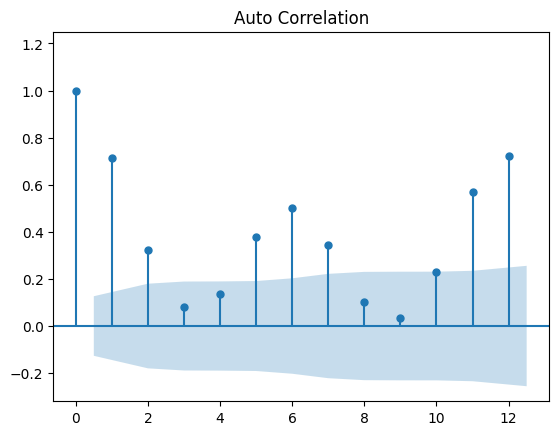

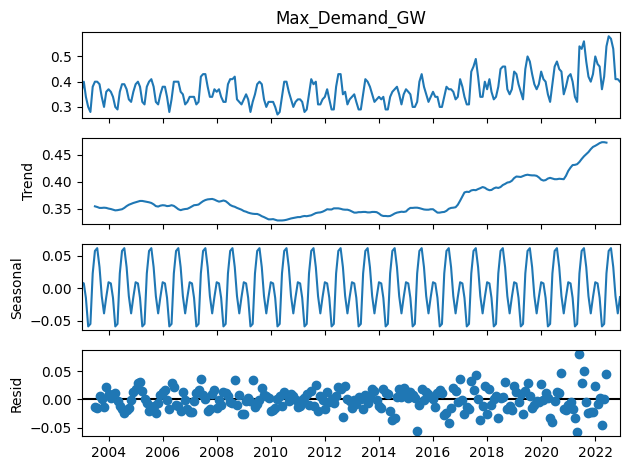

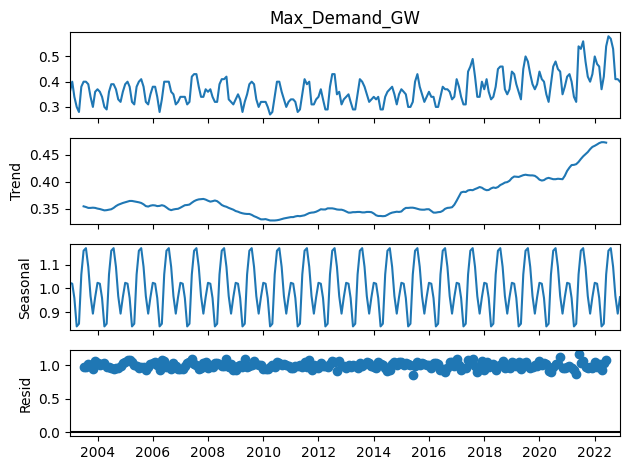

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


def wmape(y, ypred):
    """
    Calculate Weighted Mean Absolute Percentage Error (WMAPE).
    Custom error score for these NNs.

    Parameters:
    - y: numpy array, actual values
    - ypred: numpy array, predicted values

    Returns:
    - wape: float, WAPE value
    """
    absolute_errors = np.abs(y - ypred)
    wape = np.mean(absolute_errors) / np.mean(y) * 100
    return wape


PREDICTION_HORIZON = 1
LAGS = 1
all_data_ts = all_data_df[TARGET]

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(
    all_data_ts,
    lags=LAGS * 12,
    auto_ylims=True,
    title="Auto Correlation",
)

a_season = seasonal_decompose(all_data_ts, model="a", period=12)
m_season = seasonal_decompose(all_data_ts, model="m", period=12)
fig = a_season.plot()
fig = m_season.plot()
plt.show()

First plot is an **Auto Correlation Function (ACF)**:

The ACF function measures the linear predictability of $Yt$ using adjacent points in 2 timeseries ($s$ and $t$), or the lagged versions of a time series. It provides a pearson value between -1 and 1. The ACF is defined as:

$$ \rho(s, t) = \frac{\gamma(s, t)}{\sqrt{\gamma(s, s) \gamma(t, t)}} $$
Where:
- $ \rho(s, t) $ is the autocorrelation function between two time points $ s$ and $t$.
- $\gamma(s, t)$ is the autocovariance function between the same two time points.
- The denominator $\sqrt{\gamma(s, s) \gamma(t, t)}$ is the product of the square roots of the autocovariances at times $s$ and $t$, ensuring that the autocorrelation is scaled between -1 and 1.

There is significant autoregression at lags *1,2,11,12* between a pearson of *0.6* to *0.8* - indicating this dataset is Auto Regressive (AR). The shaded area represents values outside the 95% confidence interval.

Second plots are **Seasonal Decompositions** ($T$, $S$ and $C$ weights through time) for additive and multiplicative data:
- **Additive Model**: Used when there are weak variations around a trend. (seasonality is consistent in magnitude over time) - in the case of this dataset, it only created increasing noise.
- **Multiplicative Model**: Assumes variations are proportional to the level of the time series (seasonality increases in magnitude as the series increases). This suggests that there is a **unit root**.

Unit root is a characteristic of a time series that makes it non-stationary. A stationary timeseries has a finite variance and a constant mean.
Therefore a model would remove this unit root differencing the data:
- $ \Delta Y_t = Y_t - Y_{t-1} $
- $ \Delta^2 Y_t = \Delta Y_t - \Delta Y_{t-1} = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) $
- $ \Delta^d Y_t = \Delta(\Delta^{d-1} Y_t) $

Where $Y$ is a point in time and $\Delta^d Y_t $ is used when $ (d > 2) $

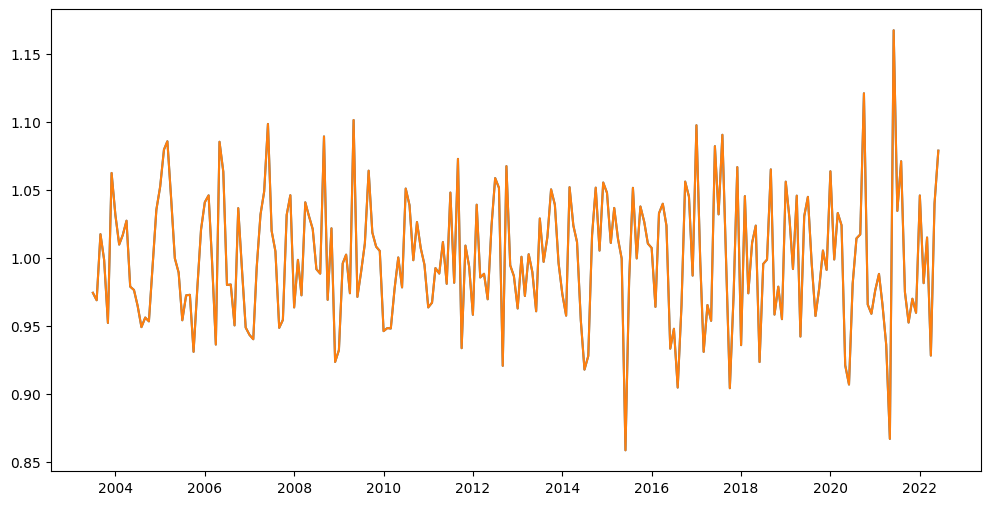

In [3]:
flat_target = all_data_ts.values / m_season.seasonal / m_season.trend

plt.figure(figsize=(12, 6))
plt.plot(all_data_ts.index, flat_target, flat_target)
plt.show()

We store the trend wieghts for predictions with non-timeseries based models.

In [4]:
df_adjustment = pd.DataFrame(
    {
        "Seasonal": m_season.seasonal,
        "Trend": m_season.trend,
        "Month": all_data_ts.index.month,
    }
)

df_adjustment = df_adjustment.groupby("Month").mean()
df_adjustment.reset_index(inplace=True)

# Save weights for future prediction
df_adjustment.to_pickle(f"{DATA_PATH}/seasonal_adjustment.pkl")
df_adjustment

,Month,Seasonal,Trend
0,1,1.023660,0.367061
1,2,1.019938,0.367829
2,3,0.960148,0.368509
3,4,0.841466,0.368969
4,5,0.852615,0.369364
5,6,1.058592,0.369693
6,7,1.157900,0.363904
7,8,1.168566,0.364364
8,9,1.090147,0.364781
9,10,0.968335,0.365197


Finally we verify test the Null Hypothesis $H0$ that the data is not stationary, using an augmented Dickey–Fuller test (ADF) which solves the following equation:

$$ \Delta Y_t = \alpha + \beta_t + \gamma Y_{t-1} + \delta_1 \Delta Y_{t-1} + \delta_2 \Delta Y_{t-2} + \cdots + \delta_p \Delta Y_{t-p} + \varepsilon_t $$
Where:
- $\Delta Y_t$ is the differenced series.
- $\alpha$ is a constant term and $\beta_t$ is a trend term.
- $\gamma$ is the coefficient of $Y_{t-1}$, the lagged value of the series, as is $\delta_1,\delta_2…,\delta_1p$ of the lagged differenced terms with $p$.
- $\varepsilon_t$ is the error.
  
$\gamma=0$, which implies the presence of a unit root its compliment $\gamma<0$ indicates stationarity rejecting the $H0$.

Using the [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function, it returns a T statistic and P-value are positive and large, meaning $H0$ is not rejected and our data is not stationary and has a unit root. For a stationary timeseries: *P-value ≤ significance level*, and *T-stat ≤ critical value*.


In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(all_data_ts.values)
print("T-stat: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

T-stat: 0.212656
p-value: 0.972963
Critial Values:
   1%, -3.459884913337196
Critial Values:
   5%, -2.8745310704320794
Critial Values:
   10%, -2.573693840082908


## Auto ARIMA model

ARIMA is an AutoRegressive Integrated Moving Average model.

An Autoregressive timeseries model that predicts $Y-t$ can be approximated as follows: 

$ Y_t = \delta t + \sum_{i=1}^{t} \epsilon_i $

Where $\delta t$ is the drift by its components, and $\epsilon_i $ is noise throughout time $t$.

Constructing the ARIMA baseline model is beyond this assignment. Instead, we will use the [AutoArima package](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to create a good enough model - we will do no further finetuning or analysis, but we use the baseline modl to compare the TCN performance.

ARIMA models are generally denoted `ARIMA(p,d,q)(P, D, Q)`, where
- `p` is the number of time lags,
- `d` is the degree of differencing, 
- `q` is the order of the moving-average model,
- `P, D, Q` is the above for the seasonal component. 

## Baseline Experiment

The code below builds, fits and predicts the baseline AutoARIMA model:

RMSE: 0.05
SMAPE: 8.22%
WMAPE: 8.36%


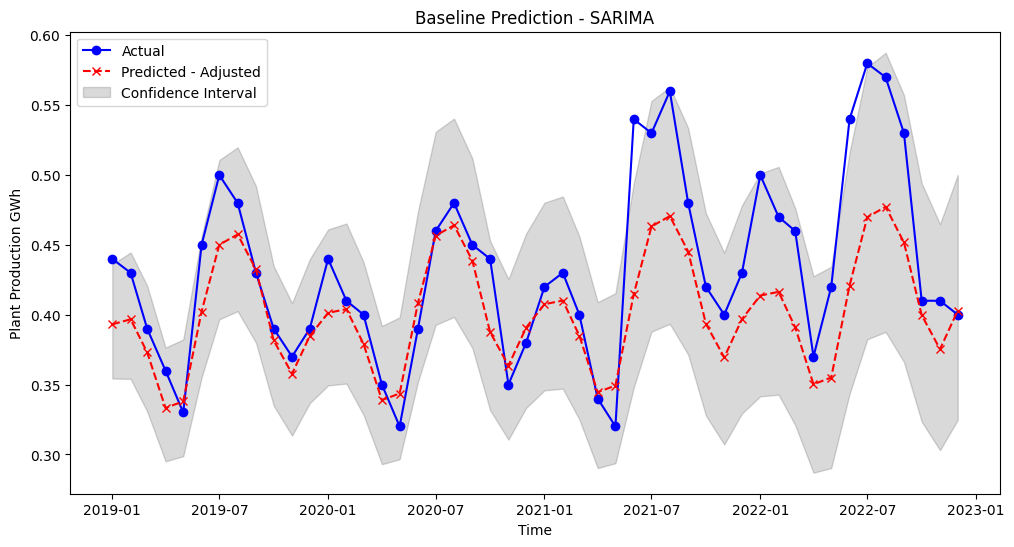

In [17]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.arima import auto_arima


def train_fit_base_arima():
    """
    Utility to create the pipelines for the baseline model.
    See: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima
    """
    train_df.index.names = [INDEX]
    arima = Pipeline(
        [
            ("boxcox", BoxCoxEndogTransformer(lmbda=0)),
            (
                "arima",
                auto_arima(
                    y=train_df[TARGET],
                    d=PREDICTION_HORIZON,  # Diffs
                    stationary=False,  # Has a trend
                    start_p=LAGS,  # Lag
                    m=12,  # Monthly seasonality
                    seasonal=True,
                    maxiter=30,
                    with_intercept=True,
                    information_criterion="bic",
                    scoring="mse",
                    stepwise=True,
                    error_action="ignore",
                    trace=False,  # Set to TRUE to see training.
                ),
            ),
        ]
    )

    arima.fit(train_df[TARGET])
    return arima


def run_base_experiment():
    """
    Train it on the train dataset.
    Estimate steps up to the lenght of the test dataset.

    No exog data will be used, this is a baseline model (and for simplicity, else we have to do recursive stepwise predictions)
    """
    arima = train_fit_base_arima()
    fc, co_int = arima.predict(
        n_periods=len(test_df), return_conf_int=True, inverse_transform=True
    )  # 4 Years

    print(f"RMSE: {mean_squared_error(test_df[TARGET], fc, squared=False):0.02f}")
    print(f"SMAPE: {smape(test_df[TARGET], fc):0.02f}%")
    print(f"WMAPE: {wmape(test_df[TARGET], fc):0.02f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")
    plt.plot(
        test_df[TARGET].index,
        fc,
        label="Predicted - Adjusted",
        color="red",
        linestyle="dashed",
        marker="x",
    )
    plt.fill_between(
        test_df.index,
        co_int[:, 0],
        co_int[:, 1],
        color="k",
        alpha=0.15,
        label="Confidence Interval",
    )

    plt.xlabel("Time")
    plt.ylabel("Plant Production GWh")
    plt.title("Baseline Prediction - SARIMA")
    plt.legend()
    plt.show()


run_base_experiment()

`Best model:  ARIMA(1,1,1)(1,0,1)[12]` means autoarima identified 1 lag across all its components except the degree of difference for the seasonal, which is stationary.



# Temporal Convolution Neural Network (TCN)

CNNs, RNNs and other stateful deeplearning models are used for timeseries (including transformers, as language is also a timeseries). The TCN is made specifically for timeseries problems, following the paper's architecture - we also migrate their code to tensorflow2 from a legacy version of keras used in their paper:
1. Input 3D Tensor of shape (batch_size, window_size, n_features)
2. Output 2D tensor of shape (batch_size, horizon)
3. 6 hidding layers (from the paper's code) comprised of:
   1. x2 1D [convulations](https://www.tensorflow.org/tutorials/structured_data/time_series#cnn) with relu activation and a spatial dropouts.
   2. 1D Dilated Convolution to capture residuals with linear activation.
   3. An addition layer to add back the [residuals](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_residual_connections) into the next layers input
4. a single dense layer fto output the next timestep according to the given horizon.
5. ADAM learning optimizer configured according to the paper.
6. Fast stop function configured according to the paper.

In [7]:
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Normalization,
    Add,
    Input,
    Lambda,
)
from tensorflow.keras import Model


class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=None,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        self.conv1 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"CONV1_{id}",
        )
        self.dropout1 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"Dropout1_{id}"
        )
        self.conv2 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"CONV2_{id}",
        )
        self.dropout2 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"Dropout2_{id}"
        )
        self.skip_out = Conv1D(
            filters=filters, kernel_size=1, activation="linear", name=f"CONV3_{id}"
        )
        self.residual_out = Add(name=f"Add_{id}")

    def apply_block(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x


def TCN(
    input_shape,
    output_horizon=1,
    num_filters=32,
    num_layers=1,
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.0,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """
    x = inputs = Input(shape=input_shape)
    for i in range(num_layers):
        block = TCNBlock(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate**i,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            id=i,
        )
        x = block.apply_block(x)
    x = Lambda(lambda x: x[:, -1:, 0])(x)
    outputs = Dense(output_horizon)(x)

    model = Model(inputs=inputs, outputs=outputs, name="TCN")
    return model

## Encoding Time Windows, Data Prep and Normalization

Encode the timesteps and windows for a recurrent network. We also normalize and check the raw values.

Tensorflow recommends encoding [date as a sine & cosine wave](https://www.tensorflow.org/tutorials/structured_data/time_series#time).

In [8]:
def encode_timewindows(data_df, features, target, window_size, horizon):
    """
    Create input and target windows suitable for TCN model.

    :param data: DataFrame with shape (n_samples, n_features)
    :param features: List of strings, names of the feature columns
    :param target: String, name of the target column
    :param window_size: int, length of the input sequence.
    :param horizon: int, forecasting horizon.
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    X, y = [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"
    ):
        input_window = data_df[features].iloc[i : i + window_size].values
        X.append(input_window)

        # Target window, note it predicts {horizon} steps ahead
        if horizon == 1:
            target_value = data_df[target].iloc[i + window_size]
        else:
            target_value = (
                data_df[target].iloc[i + window_size : i + window_size + horizon].values
            )
        y.append(target_value)
    return np.array(X), np.array(y)



MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"



def encode_cyclics(data_df):

    """



    Encodes time cyclic features for a dataset with monthly sampling.



    Assuming we can capture the yearly periodicity by encoding the month as a wave.



    See: https://www.tensorflow.org/tutorials/structured_data/time_series#time



    :param data_df: The timeseries with a date in the format YYYY-DD-mm as index.



    :return: data_df with 2 new wave features.



    """
    months = data_df.index.month

    data_df[MONTH_SINE] = np.sin(2 * np.pi * months / 12)
    data_df[MONTH_COS] = np.cos(2 * np.pi * months / 12)
    return data_df



WINDOW_SIZE_MONTHS = 12



EXT_FEATURES = FEATURES + [TARGET, MONTH_SINE, MONTH_COS]



def prepare_data_and_windows(
    data_df, window=WINDOW_SIZE_MONTHS, horizon=PREDICTION_HORIZON
):
    """



    Utility function to prepare the data. Assuming features are:
        - 'Plant_Production_GWh
        - 'emissions_c02_GG'
        - 'tavg',
        - 'GDP_bln'
        - 'date' in YYYY-DD-MM,
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)



    """

    normalizer = Normalization(axis=-1)

    normalizer.adapt(data_df[FEATURES])
    data_df_normalized = normalizer(data_df[FEATURES])
    data_df_normalized = pd.DataFrame(
        data_df_normalized, columns=FEATURES, index=data_df.index
    )
    data_df_normalized = encode_cyclics(data_df_normalized)

    X, y = encode_timewindows(

        pd.concat([data_df[TARGET], data_df_normalized], axis=1),
        EXT_FEATURES,
        TARGET,
        window,

        horizon,
    )

    print(

        f"FEATURES: {EXT_FEATURES}, TARGET: '{TARGET}', window: {WINDOW_SIZE_MONTHS}, horizon: {PREDICTION_HORIZON}"
    )
    print(
        f"Shape unencoded (including target label and superflous features): {data_df.shape}"
    )
    print(f"Shape encoded (window and selected exog features only): {X.shape}")

    return X, y, normalizer



X, y, normalizer = prepare_data_and_windows(all_data_df)
print(f"Label shape encoded: {y.shape}")
print(f"First window exog normalized: {X[0, 1:, :]}")
print(f"First window targets: {y[0:11]}")


input_shape = (WINDOW_SIZE_MONTHS, X.shape[2])
input_shape

Encoding Widows: 100%|██████████| 228/228 [00:00<00:00, 1872.33it/s]

FEATURES: ['Plant_Production_GWh', 'emissions_c02_GG', 'tavg', 'GDP_bln', 'Max_Demand_GW', 'month_sin', 'month_cos'], TARGET: 'Max_Demand_GW', window: 12, horizon: 1
Shape unencoded (including target label and superflous features): (240, 10)
Shape encoded (window and selected exog features only): (228, 12, 7)
Label shape encoded: (228,)
First window exog normalized: [[-2.43314236e-01 -6.02663793e-02 -1.68626821e+00 -1.15034938e+00
   4.00000000e-01  8.66025404e-01  5.00000000e-01]
 [-5.86296439e-01 -7.57323503e-01 -1.25902200e+00 -1.15034938e+00
   3.40000000e-01  1.00000000e+00  6.12323400e-17]
 [-1.22047710e+00 -1.22202861e+00 -7.38896132e-01 -1.15034938e+00
   3.00000000e-01  8.66025404e-01 -5.00000000e-01]
 [-9.82659221e-01 -1.45438099e+00  1.71324030e-01 -1.15034938e+00
   2.80000000e-01  5.00000000e-01 -8.66025404e-01]
 [-2.37165261e-02 -2.92618752e-01  1.23015177e+00 -1.15034938e+00
   3.80000000e-01  1.22464680e-16 -1.00000000e+00]
 [ 1.22226954e+00 -6.02663793e-02  1.73170149e

(12, 7)

## Fit and Train TCN

Build and train the TCN according to the current parameters selected.

In [9]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from sklearn.model_selection import ParameterGrid

EPOCHS = 300
BATCH_SIZE = 32
FILTER = 128
DROPRATE = 0.5
POOL_SIZE = 2
KERNEL_SIZE = 4
DILATION_RATE = 4
MAX_LAYERS = 4
L2_REG = 0.005
LEARN_RATE = 0.0001
MODEL_LOG_DIR = f'./logs/{datetime.now().strftime("%m%d-%H%M%S")}'
# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
GRID = {
    "num_filters": [32, 64, 128],
    "kernel_size": [2, 3, 4],
    "dilation_rate": [1, 2, 4],
    "dropout_rate": [0.1, 0.2, 0.3],
    "num_layers": [6, 5, 3],
    "l2_reg": [0.005, 0.001, 0.01],
    "learning_rate": [0.001, 0.01, 0.1],
}


def build_tcn(X, y):
    model = TCN(
        input_shape=input_shape,
        output_horizon=PREDICTION_HORIZON,
        num_filters=FILTER,
        kernel_size=KERNEL_SIZE,
        num_layers=MAX_LAYERS,
        dilation_rate=DILATION_RATE,
        kernel_regularizer=L2(l2=L2_REG),
        bias_regularizer=L2(l2=L2_REG),
    )

    # See: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
    optimizer = Adam(LEARN_RATE)
    metrics = ["mse", "mae", "mape"]
    model.compile(loss="mse", optimizer=optimizer, metrics=metrics)

    # Paper's `patience` was 50, we limited to 10
    # see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    # VERBOSE set to 0 to keep nb clean.
    callbacks = [
        EarlyStopping(patience=10, monitor="val_loss"),
        TensorBoard(log_dir=MODEL_LOG_DIR),
    ]
    history = model.fit(
        X,
        y,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=0,
    )
    return model, history


model, history = build_tcn(X, y)
model.summary()

Model: "TCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 CONV1_0 (Conv1D)               (None, 12, 128)      3584        ['input_1[0][0]']                
                                                                                                  
 Dropout1_0 (SpatialDropout1D)  (None, 12, 128)      0           ['CONV1_0[0][0]']                
                                                                                                  
 CONV2_0 (Conv1D)               (None, 12, 128)      65536       ['Dropout1_0[0][0]']             
                                                                                                

[Tensorboard](https://www.tensorflow.org/tensorboard/get_started), enabled by the callback configured in the build, should allow us to observe the NN created.

It has it quirks, and might not run on your machine - in that case you can skip the next section.

In [10]:
%load_ext tensorboard
# https://github.com/tensorflow/tensorboard/issues/2481
%tensorboard --logdir {MODEL_LOG_DIR} --host localhost

We check the raw value outputs of the model

In [11]:
VAL_SIZE = round(len(X) * VAL_SPLIT)

train_data = X[:-VAL_SIZE]
test_data = X[-VAL_SIZE:]
ytrain_data = y[:-VAL_SIZE]
ytest_data = y[-VAL_SIZE:]
print(ytest_data.shape)
print(ytest_data)

(46,)
[0.39 0.36 0.33 0.45 0.5  0.48 0.43 0.39 0.37 0.39 0.44 0.41 0.4  0.35
 0.32 0.39 0.46 0.48 0.45 0.44 0.35 0.38 0.42 0.43 0.4  0.34 0.32 0.54
 0.53 0.56 0.48 0.42 0.4  0.43 0.5  0.47 0.46 0.37 0.42 0.54 0.58 0.57
 0.53 0.41 0.41 0.4 ]


In [12]:
y_pred = model.predict(train_data)
yt_pred = model.predict(test_data)

print(yt_pred.shape)
print(yt_pred.flatten())

2/2 [==============================] - 0s 0s/step
(46, 1)
[0.3968591  0.36406943 0.36852986 0.3924913  0.46185976 0.49509144
 0.4613704  0.4044095  0.39330056 0.40698707 0.4229514  0.43095008
 0.383641   0.36868915 0.3559375  0.3721887  0.4241941  0.4678919
 0.45676896 0.4075135  0.39437345 0.37922576 0.40974224 0.42911312
 0.39963013 0.3809789  0.3669194  0.38553393 0.49918365 0.51140016
 0.5001402  0.43443662 0.4097786  0.4273548  0.45991203 0.48430115
 0.4284418  0.41909623 0.39617047 0.44574624 0.5199863  0.5536523
 0.5223099  0.47114068 0.42633966 0.4491038 ]


## Loss and Errors

In the graphs below, we visualize how the loss and errors progress through training epochs.

Note how the model might not be generalizing well, given the delta between the training and validation errors.

shapes y_pred: (182, 1) and yt_pred: (46, 1)
RMSE train: 0.0208
RMSE test: 0.0398
MSE train: 0.0004
MSE test: 0.0016
SMAPE train: 4.58%
SMAPE test: 6.79%
WMAPE train: 12.61%
WMAPE test: 15.24%
r2: 0.645814254457663


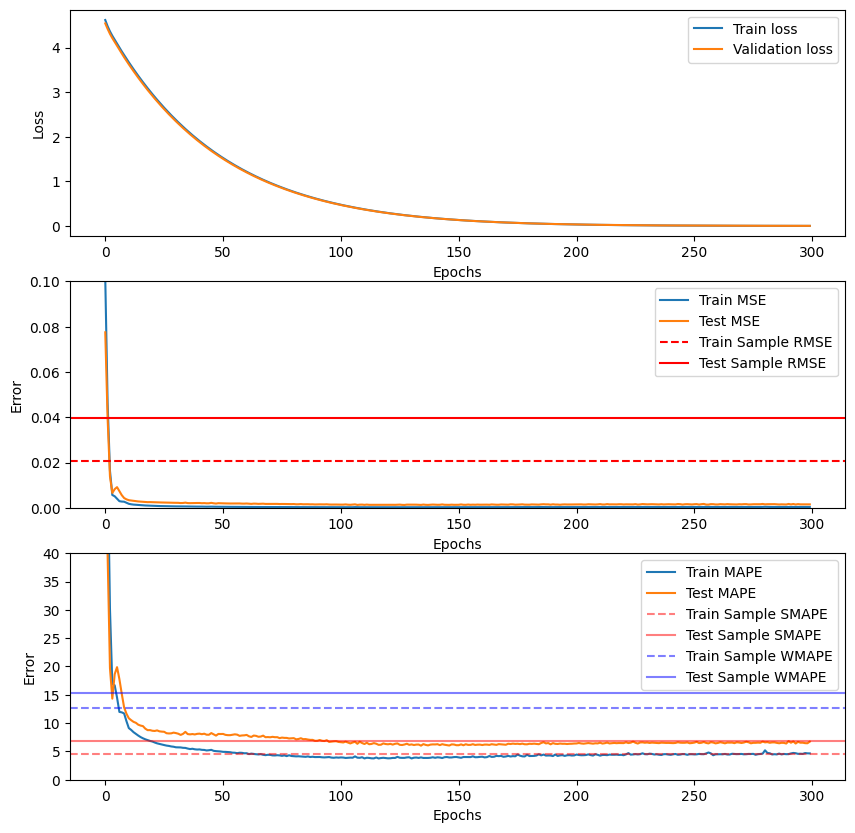

In [13]:
from sklearn.metrics import r2_score

rmse_train = mean_squared_error(ytrain_data, y_pred, squared=False)
rmse_test = mean_squared_error(ytest_data, yt_pred, squared=False)
mse_train = mean_squared_error(ytrain_data, y_pred, squared=True)
mse_test = mean_squared_error(ytest_data, yt_pred, squared=True)
smape_train = smape(ytrain_data, y_pred)
smape_test = smape(ytest_data, yt_pred)
wmape_train = wmape(ytrain_data, y_pred)
wmape_test = wmape(ytest_data, yt_pred)


print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")
print(f"RMSE train: {rmse_train:0.04f}")
print(f"RMSE test: {rmse_test:0.04f}")
print(f"MSE train: {mse_train:0.04f}")
print(f"MSE test: {mse_test:0.04f}")
print(f"SMAPE train: {smape_train:0.02f}%")
print(f"SMAPE test: {smape_test:0.02f}%")
print(f"WMAPE train: {wmape_train:0.02f}%")
print(f"WMAPE test: {wmape_test:0.02f}%")

r2 = r2_score(
    ytest_data,
    yt_pred,
)
print(f"r2: {r2}")

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(
    history.history["mse"],
    label="Train MSE",
)
axs[1].plot(
    history.history["val_mse"],
    label="Test MSE",
)
axs[1].set_ylim((0, 0.1))
axs[1].axhline(rmse_train, color="r", linestyle="--", label="Train Sample RMSE")
axs[1].axhline(rmse_test, color="r", linestyle="-", label="Test Sample RMSE")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Error")
axs[1].legend()
axs[2].plot(
    history.history["mape"],
    label="Train MAPE",
)
axs[2].plot(
    history.history["val_mape"],
    label="Test MAPE",
)
axs[2].axhline(
    smape_train, color="r", linestyle="--", label="Train Sample SMAPE", alpha=0.5
)
axs[2].axhline(
    smape_test, color="r", linestyle="-", label="Test Sample SMAPE", alpha=0.5
)
axs[2].axhline(
    wmape_train, color="b", linestyle="--", label="Train Sample WMAPE", alpha=0.5
)
axs[2].axhline(
    wmape_test, color="b", linestyle="-", label="Test Sample WMAPE", alpha=0.5
)
axs[2].set_ylim((0, 40))
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Error")
axs[2].legend()
plt.show()

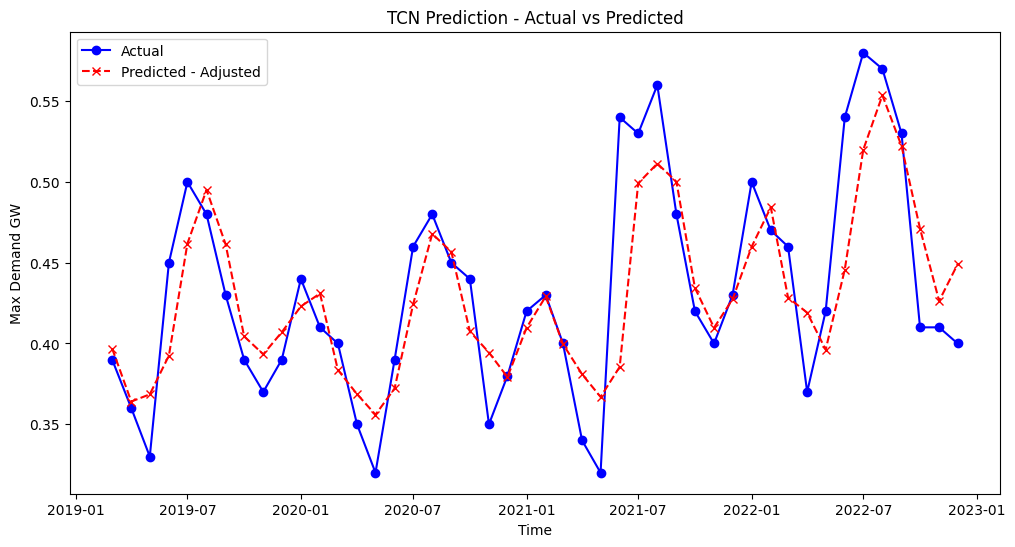

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(
    all_data_df.index[-VAL_SIZE:], ytest_data, label="Actual", color="blue", marker="o"
)
plt.plot(
    all_data_df.index[-VAL_SIZE:],
    yt_pred,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Max Demand GW")
plt.title("TCN Prediction - Actual vs Predicted")
plt.legend()
plt.show()

# Save and Validate Model

We save the model and wieghts.

In [15]:
from tensorflow.keras.models import load_model

MODEL_PATH = "./models/tcn"

model.save(MODEL_PATH)
val_model = load_model(MODEL_PATH)

val_model.summary()

INFO:tensorflow:Assets written to: ./models/tcn\assets


INFO:tensorflow:Assets written to: ./models/tcn\assets


Model: "TCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 CONV1_0 (Conv1D)               (None, 12, 128)      3584        ['input_1[0][0]']                
                                                                                                  
 Dropout1_0 (SpatialDropout1D)  (None, 12, 128)      0           ['CONV1_0[0][0]']                
                                                                                                  
 CONV2_0 (Conv1D)               (None, 12, 128)      65536       ['Dropout1_0[0][0]']             
                                                                                                

We do some spot predictions.

In [16]:
# Our test set has 2yrs, we get the last nov to nov window, and predict dec.
# if this slicing is confusing, we grab the last 13 months (+2) and slice it to before the 13th (-1)
window_12month_df = test_df.iloc[-(WINDOW_SIZE_MONTHS + 2) : -1]
ext_test_x, _, _ = prepare_data_and_windows(
    window_12month_df, window=WINDOW_SIZE_MONTHS, horizon=1
)
y_13th_month = val_model.predict(ext_test_x)
print(
    f"For [{test_df.tail(1).index[0]}]: Predicted {y_13th_month[0]} vs Actual {test_df.tail(1)[TARGET].values}"
)

Encoding Widows: 100%|██████████| 1/1 [00:00<?, ?it/s]


FEATURES: ['Plant_Production_GWh', 'emissions_c02_GG', 'tavg', 'GDP_bln', 'Max_Demand_GW', 'month_sin', 'month_cos'], TARGET: 'Max_Demand_GW', window: 12, horizon: 1
Shape unencoded (including target label and superflous features): (13, 10)
Shape encoded (window and selected exog features only): (1, 12, 7)
1/1 [==============================] - 0s 283ms/step
For [2022-12-01 00:00:00]: Predicted [0.38035318] vs Actual [0.4]
